<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/20_1_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


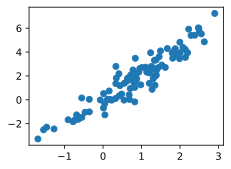

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [ ]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [ ]:
net_G = nn.Sequential(nn.Linear(2, 2))

In [ ]:
net_D = nn.Sequential(
    nn.Linear(2,5), nn.Tanh(),
    nn.Linear(5,3), nn.Tanh(),
    nn.Linear(3,1)
)

In [ ]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
  batch_size = X.shape[0]
  ones = torch.ones((batch_size,), device=X.device)
  zeros = torch.zeros((batch_size,), device=X.device)
  trainer_D.zero_grad()
  real_Y = net_D(X)
  fake_X = net_G(Z)

  fake_Y = net_D(fake_X.detach())
  loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
            loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
  loss_D.backward()
  trainer_D.step()
  return loss_D

In [ ]:
def update_G(Z, net_D, net_G, loss, trainer_G):
  batch_size  = Z.shape[0]
  ones = torch.ones((batch_size,), device=Z.device)
  trainer_G.zero_grad()
  fake_X = net_G(Z)
  fake_Y = net_D(fake_X)
  loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
  loss_G.backward()
  trainer_G.step()
  return loss_G

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
  loss = nn.BCEWithLogitsLoss(reduction='sum')
  for w in net_D.parameters():
    nn.init.normal_(w, 0, 0.02)
  for w in net_G.parameters():
    nn.init.normal_(w, 0, 0.02)
  trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
  trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[1, num_epochs], nrows=2, figsize=(5,5),
                          legend=['discriminator', 'generator'])
  animator.fig.subplots_adjust(hspace=0.3)
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(3)
    for (X,) in data_iter:
      batch_size =  X.shape[0]
      Z = torch.normal(0,1, size=(batch_size, latent_dim))
      metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                 update_G(Z, net_D, net_G, loss, trainer_G),
                 batch_size)

    Z = torch.normal(0,1, size=(100, latent_dim))
    fake_X = net_G(Z).detach().numpy()
    animator.axes[1].cla()
    animator.axes[1].scatter(data[:,0], data[:, 1])
    animator.axes[1].scatter(fake_X[:,0], fake_X[:, 1])
    animator.axes[1].legend(['real', 'generated'])

    # Show the losses
    loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
    animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 0.693, loss_G 0.693, 864.7 examples/sec


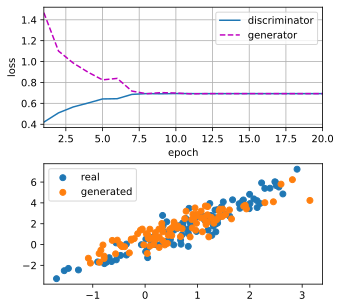

In [ ]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].detach().numpy())